In [1]:
import numpy as np
import pandas as pd

import lingam

from IPython.display import Markdown
import matplotlib.pyplot as plt
import networkx as nx
import graphviz as gv

np.random.seed(0)

## 1.サンプルデータ

In [2]:
sample_size = 1000
n_features = 6

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, sample_size))
e = pd.DataFrame(e.T, columns=[f"e{i + 1}" for i in range(n_features)])

B = np.array([
    [ 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [ 0.50, 0.00, 0.00, 0.00, 0.00, 0.00],
    [-0.20, 0.00, 0.00, 0.00, 0.00, 0.00],
    [ 0.00,-0.40, 0.00, 0.00, 0.00, 0.00],
    [ 0.00, 0.30, 0.20, 0.00, 0.00, 0.00],
    [ 0.00, 0.00, 0.80, 0.00, 0.00, 0.00],
])

# X = BX + e => X = (I - B)^-1 e
X = np.linalg.pinv(np.eye(n_features) - B) @ e.T

X = pd.DataFrame(X.values.T, columns=[f"x{i + 1}" for i in range(n_features)])

X.shape

(1000, 6)

### 誤差項の分散

In [3]:
e.var()

e1    1.014387
e2    1.073586
e3    0.987662
e4    0.983275
e5    0.954916
e6    1.011167
dtype: float64

### 各変数の分散

In [4]:
X.var()

x1    1.014387
x2    1.333461
x3    1.040344
x4    1.227961
x5    1.078229
x6    1.659683
dtype: float64

### 因果グラフ

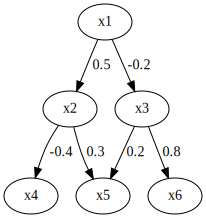

In [5]:
G = nx.from_numpy_array(B.T, create_using=nx.DiGraph)

dot = gv.Digraph()
for from_, to in G.edges:
    dot.edge(f"x{from_ + 1}", f"x{to + 1}", label=f"{B[to, from_]}")
dot

## 2. LiNGAMによる因果探索

### 2.1. 単純に推定
データから隣接行列Bを推定する。また結果をグラフとして描画する。

### 推定結果

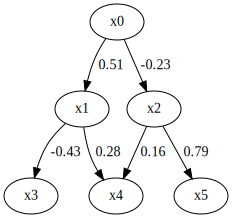

### 正解

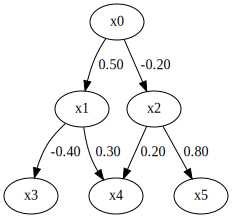

In [6]:
model = lingam.DirectLiNGAM()
model.fit(X)

display(Markdown("### 推定結果"))
#display(pd.DataFrame(model.adjacency_matrix_))
display(lingam.utils.make_dot(model.adjacency_matrix_, lower_limit=0))

display(Markdown("### 正解"))
#display(pd.DataFrame(B))
display(lingam.utils.make_dot(B, lower_limit=0))

### 2.2. ブートストラップ

推定ごとに結果が変わって安定しないことが多いため、実際にはブートストラップを行って頻出の構造などを確認する。

https://lingam.readthedocs.io/en/latest/tutorial/bootstrap.html

In [7]:
model = lingam.DirectLiNGAM()
bs_result = model.bootstrap(X, n_sampling=100)

因果の向きの確率を表示する。エッジの大きさの最小値を0.01に、正負で別物として扱うように設定している。

In [8]:
cdc = bs_result.get_causal_direction_counts(n_directions=20, min_causal_effect=0.01, split_by_causal_effect_sign=True)
lingam.utils.print_causal_directions(cdc, 100)

x1 <--- x0 (b>0) (100.0%)
x2 <--- x0 (b<0) (100.0%)
x3 <--- x1 (b<0) (100.0%)
x5 <--- x2 (b>0) (100.0%)
x4 <--- x1 (b>0) (100.0%)
x4 <--- x2 (b>0) (99.0%)
x2 <--- x3 (b>0) (10.0%)
x4 <--- x5 (b>0) (6.0%)
x2 <--- x1 (b>0) (5.0%)
x4 <--- x3 (b>0) (4.0%)
x5 <--- x1 (b>0) (2.0%)
x5 <--- x0 (b<0) (1.0%)
x3 <--- x2 (b>0) (1.0%)
x3 <--- x0 (b<0) (1.0%)
x1 <--- x5 (b<0) (1.0%)
x1 <--- x2 (b>0) (1.0%)
x4 <--- x0 (b<0) (1.0%)
x5 <--- x3 (b<0) (1.0%)


頻出のDAGを確認する。

In [9]:
dagc = bs_result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
lingam.utils.print_dagc(dagc, 100)

DAG[0]: 71.0%
	x1 <--- x0 (b>0)
	x2 <--- x0 (b<0)
	x3 <--- x1 (b<0)
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x5 <--- x2 (b>0)
DAG[1]: 7.0%
	x1 <--- x0 (b>0)
	x2 <--- x0 (b<0)
	x2 <--- x3 (b>0)
	x3 <--- x1 (b<0)
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x5 <--- x2 (b>0)
DAG[2]: 5.0%
	x1 <--- x0 (b>0)
	x2 <--- x0 (b<0)
	x3 <--- x1 (b<0)
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x5 (b>0)
	x5 <--- x2 (b>0)


エッジの存在確率を確認する。

In [10]:
prob = bs_result.get_probabilities(min_causal_effect=0.01)
print(prob)

[[0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.01 0.   0.   0.01]
 [1.   0.05 0.   0.1  0.   0.  ]
 [0.01 1.   0.01 0.   0.   0.  ]
 [0.01 1.   0.99 0.04 0.   0.06]
 [0.01 0.02 1.   0.01 0.   0.  ]]


総合因果効果の存在確率と中央値

In [11]:
causal_effects = bs_result.get_total_causal_effects(min_causal_effect=0.01)

df = pd.DataFrame(causal_effects)
labels = [f'x{i}' for i in range(X.shape[1])]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect,probability
0,x0,x1,0.504106,1.00
1,x0,x5,-0.186590,1.00
2,x0,x2,-0.237612,1.00
3,x0,x3,-0.215339,1.00
4,x1,x3,-0.428827,1.00
5,x2,x5,0.790254,1.00
6,x0,x4,0.106454,1.00
7,x1,x4,0.287870,1.00
8,x2,x4,0.156800,0.99
9,x1,x5,0.022387,0.15


パスの存在確率

In [12]:
from_index = 0
to_index = 3

pd.DataFrame(bs_result.get_paths(from_index, to_index))

,path,effect,probability
0,"[0, 1, 3]",-0.215062,1.00
1,"[0, 2, 1, 3]",0.010431,0.01
2,"[0, 2, 3]",-0.019310,0.01
3,"[0, 2, 5, 1, 3]",-0.005897,0.01
4,"[0, 3]",-0.105952,0.01


潜在変数を仮定したモデル、巡回を許容するモデル、時系列データに対応したモデル、縦断分析に対応したモデル…など色々な派生があるので、データに応じて使い分けるとよい。